# Text preprocessing

## Import and setup pandas dataframe

In [26]:
# Pandas is used for data manipulation
import numpy as np
import pandas as pd
import contractions
import fasttext
import string
fasttext.FastText.eprint = lambda x: None


# NLTK tokenization, stopword removal and vader 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
analyzer = SIA()

In [13]:
# Read in data and display first 10 rows
pd.set_option("display.max_colwidth", 10000)
df = pd.read_csv('src/2018_pinkbike_comments.csv')
df.head(10)

,id,article_id,comment_author_id,comment_html_id,comment_publishing_date,comment_upvotes,comment_downvotes,comment_content
0,1,1,1,1898605,1517781780,1,0,"Hey man. Note: 1-6 month is a forest fire prevention season in Kunming, and some forest trails may not be allowed to enter.But some forest trails are still allowed to enter. You can't use a fire source."
1,2,1,2,1896303,1517802540,1,0,Hey hoop. Yep I know about the fire prevention. Thankfully they don't close off Bao Zhu. Let's ride sometime!
2,3,1,3,1897961,1517441160,1,0,难得在国际版看到中国内容
3,4,1,2,1896280,1517457120,1,0,我希望能写更多有关中国单车的内容
4,5,1,4,1896452,1517596320,1,0,来多几段，这么多的活动没人报道
5,6,3,7,1896246,1517424960,30,0,Matt Jones' video Frames of Mind video was one of the best from last year.
6,7,3,8,1896306,1517441280,18,1,I had literally never considered that they might be brothers. This is embarrassing.
7,8,3,9,1896267,1517444640,15,0,"I actually thought for a while it was the same person, Jono being the nickname or something like that..."
8,9,3,10,1896260,1517459940,1,0,@bonkywonky: Makes two of dude!
9,10,3,11,1896288,1517460540,3,0,"I have to say, to my shame, that before this video I never even realized Matt had a sibling at all, especially not a twin... :O"


In [14]:
df.drop("id", axis = 1, inplace = True)

In [15]:
print (list(df))

['article_id', 'comment_author_id', 'comment_html_id', 'comment_publishing_date', 'comment_upvotes', 'comment_downvotes', 'comment_content']


In [16]:
for col in df.columns:
    print(col, df[col].isna().sum())

article_id 0
comment_author_id 0
comment_html_id 0
comment_publishing_date 0
comment_upvotes 0
comment_downvotes 0
comment_content 26


In [17]:
df.dropna(axis = 0, inplace = True)

In [18]:
cmnts = df.loc[:, ["comment_publishing_date", "comment_upvotes", "comment_downvotes", "comment_content"]]

# Text preprocessing

## Expanding shortforms

In [19]:
cmnts["no_contract"] = cmnts['comment_content'].apply(lambda x: [contractions.fix(word) for word in x.split()])
cmnts["comment_content_str"] = [' '.join(map(str, l)) for l in cmnts['no_contract']]
cmnts.head()

,comment_publishing_date,comment_upvotes,comment_downvotes,comment_content,no_contract,comment_content_str
0,1517781780,1,0,"Hey man. Note: 1-6 month is a forest fire prevention season in Kunming, and some forest trails may not be allowed to enter.But some forest trails are still allowed to enter. You can't use a fire source.","[Hey, man., Note:, 1-6, month, is, a, forest, fire, prevention, season, in, Kunming,, and, some, forest, trails, may, not, be, allowed, to, enter.But, some, forest, trails, are, still, allowed, to, enter., You, can not, use, a, fire, source.]","Hey man. Note: 1-6 month is a forest fire prevention season in Kunming, and some forest trails may not be allowed to enter.But some forest trails are still allowed to enter. You can not use a fire source."
1,1517802540,1,0,Hey hoop. Yep I know about the fire prevention. Thankfully they don't close off Bao Zhu. Let's ride sometime!,"[Hey, hoop., Yep, I, know, about, the, fire, prevention., Thankfully, they, do not, close, off, Bao, Zhu., let us, ride, sometime!]",Hey hoop. Yep I know about the fire prevention. Thankfully they do not close off Bao Zhu. let us ride sometime!
2,1517441160,1,0,难得在国际版看到中国内容,[难得在国际版看到中国内容],难得在国际版看到中国内容
3,1517457120,1,0,我希望能写更多有关中国单车的内容,[我希望能写更多有关中国单车的内容],我希望能写更多有关中国单车的内容
4,1517596320,1,0,来多几段，这么多的活动没人报道,[来多几段，这么多的活动没人报道],来多几段，这么多的活动没人报道


## Detect language and delete non-english comments

In [20]:
pretrained_model = "src/lid.176.bin"
model = fasttext.load_model(pretrained_model)
langs = []

for sent in cmnts["comment_content_str"]:
    lang = model.predict(sent)[0]
    langs.append(str(lang)[11:13])
cmnts["langs"] = langs

new_cmnts = cmnts[~cmnts["langs"].str.contains("en", na = False)]

# Get indexes of foreign languages
indexNames = new_cmnts.index 

# Delete these row indexes from dataFrame
cmnts.drop(indexNames , inplace = True)
cmnts.head()

,comment_publishing_date,comment_upvotes,comment_downvotes,comment_content,no_contract,comment_content_str,langs
0,1517781780,1,0,"Hey man. Note: 1-6 month is a forest fire prevention season in Kunming, and some forest trails may not be allowed to enter.But some forest trails are still allowed to enter. You can't use a fire source.","[Hey, man., Note:, 1-6, month, is, a, forest, fire, prevention, season, in, Kunming,, and, some, forest, trails, may, not, be, allowed, to, enter.But, some, forest, trails, are, still, allowed, to, enter., You, can not, use, a, fire, source.]","Hey man. Note: 1-6 month is a forest fire prevention season in Kunming, and some forest trails may not be allowed to enter.But some forest trails are still allowed to enter. You can not use a fire source.",en
1,1517802540,1,0,Hey hoop. Yep I know about the fire prevention. Thankfully they don't close off Bao Zhu. Let's ride sometime!,"[Hey, hoop., Yep, I, know, about, the, fire, prevention., Thankfully, they, do not, close, off, Bao, Zhu., let us, ride, sometime!]",Hey hoop. Yep I know about the fire prevention. Thankfully they do not close off Bao Zhu. let us ride sometime!,en
5,1517424960,30,0,Matt Jones' video Frames of Mind video was one of the best from last year.,"[Matt, Jones', video, Frames, of, Mind, video, was, one, of, the, best, from, last, year.]",Matt Jones' video Frames of Mind video was one of the best from last year.,en
6,1517441280,18,1,I had literally never considered that they might be brothers. This is embarrassing.,"[I, had, literally, never, considered, that, they, might, be, brothers., This, is, embarrassing.]",I had literally never considered that they might be brothers. This is embarrassing.,en
7,1517444640,15,0,"I actually thought for a while it was the same person, Jono being the nickname or something like that...","[I, actually, thought, for, a, while, it, was, the, same, person,, Jono, being, the, nickname, or, something, like, that...]","I actually thought for a while it was the same person, Jono being the nickname or something like that...",en


## Remove URLs

In [21]:
cmnts['no_url'] = cmnts['comment_content_str'].replace(r'http\S+', '', regex = True).replace(r'www\S+', '', regex = True)
cmnts.head()

,comment_publishing_date,comment_upvotes,comment_downvotes,comment_content,no_contract,comment_content_str,langs,no_url
0,1517781780,1,0,"Hey man. Note: 1-6 month is a forest fire prevention season in Kunming, and some forest trails may not be allowed to enter.But some forest trails are still allowed to enter. You can't use a fire source.","[Hey, man., Note:, 1-6, month, is, a, forest, fire, prevention, season, in, Kunming,, and, some, forest, trails, may, not, be, allowed, to, enter.But, some, forest, trails, are, still, allowed, to, enter., You, can not, use, a, fire, source.]","Hey man. Note: 1-6 month is a forest fire prevention season in Kunming, and some forest trails may not be allowed to enter.But some forest trails are still allowed to enter. You can not use a fire source.",en,"Hey man. Note: 1-6 month is a forest fire prevention season in Kunming, and some forest trails may not be allowed to enter.But some forest trails are still allowed to enter. You can not use a fire source."
1,1517802540,1,0,Hey hoop. Yep I know about the fire prevention. Thankfully they don't close off Bao Zhu. Let's ride sometime!,"[Hey, hoop., Yep, I, know, about, the, fire, prevention., Thankfully, they, do not, close, off, Bao, Zhu., let us, ride, sometime!]",Hey hoop. Yep I know about the fire prevention. Thankfully they do not close off Bao Zhu. let us ride sometime!,en,Hey hoop. Yep I know about the fire prevention. Thankfully they do not close off Bao Zhu. let us ride sometime!
5,1517424960,30,0,Matt Jones' video Frames of Mind video was one of the best from last year.,"[Matt, Jones', video, Frames, of, Mind, video, was, one, of, the, best, from, last, year.]",Matt Jones' video Frames of Mind video was one of the best from last year.,en,Matt Jones' video Frames of Mind video was one of the best from last year.
6,1517441280,18,1,I had literally never considered that they might be brothers. This is embarrassing.,"[I, had, literally, never, considered, that, they, might, be, brothers., This, is, embarrassing.]",I had literally never considered that they might be brothers. This is embarrassing.,en,I had literally never considered that they might be brothers. This is embarrassing.
7,1517444640,15,0,"I actually thought for a while it was the same person, Jono being the nickname or something like that...","[I, actually, thought, for, a, while, it, was, the, same, person,, Jono, being, the, nickname, or, something, like, that...]","I actually thought for a while it was the same person, Jono being the nickname or something like that...",en,"I actually thought for a while it was the same person, Jono being the nickname or something like that..."


## Clear table

In [22]:
delete_columns = ["comment_content", "no_contract", "comment_content_str", "langs"]
cmnts.drop(delete_columns, inplace = True, axis = 1)
cmnts.rename(columns = {"no_url": "comments"}, inplace = True)
cmnts.head()

,comment_publishing_date,comment_upvotes,comment_downvotes,comments
0,1517781780,1,0,"Hey man. Note: 1-6 month is a forest fire prevention season in Kunming, and some forest trails may not be allowed to enter.But some forest trails are still allowed to enter. You can not use a fire source."
1,1517802540,1,0,Hey hoop. Yep I know about the fire prevention. Thankfully they do not close off Bao Zhu. let us ride sometime!
5,1517424960,30,0,Matt Jones' video Frames of Mind video was one of the best from last year.
6,1517441280,18,1,I had literally never considered that they might be brothers. This is embarrassing.
7,1517444640,15,0,"I actually thought for a while it was the same person, Jono being the nickname or something like that..."


## Vader sentiment analysis

In [27]:
# Generating sentiment for all the sentence present in the dataset
emptyline=[]

for row in cmnts["comments"]:
    vs = analyzer.polarity_scores(row)
    emptyline.append(vs)
    
# Creating new dataframe with sentiments
df_sentiments = pd.DataFrame(emptyline)
df_sentiments.head()

,neg,neu,pos,compound
0,0.124,0.876,0.000,-0.5859
1,0.097,0.688,0.214,0.4389
2,0.000,0.769,0.231,0.6369
3,0.191,0.809,0.000,-0.3818
4,0.000,0.865,0.135,0.3612


In [30]:
# Merging the sentiments back to reviews dataframe
df_c = pd.concat([cmnts.reset_index(drop = True), df_sentiments], axis = 1)
df_c.head()

,comment_publishing_date,comment_upvotes,comment_downvotes,comments,neg,neu,pos,compound
0,1517781780,1,0,"Hey man. Note: 1-6 month is a forest fire prevention season in Kunming, and some forest trails may not be allowed to enter.But some forest trails are still allowed to enter. You can not use a fire source.",0.124,0.876,0.000,-0.5859
1,1517802540,1,0,Hey hoop. Yep I know about the fire prevention. Thankfully they do not close off Bao Zhu. let us ride sometime!,0.097,0.688,0.214,0.4389
2,1517424960,30,0,Matt Jones' video Frames of Mind video was one of the best from last year.,0.000,0.769,0.231,0.6369
3,1517441280,18,1,I had literally never considered that they might be brothers. This is embarrassing.,0.191,0.809,0.000,-0.3818
4,1517444640,15,0,"I actually thought for a while it was the same person, Jono being the nickname or something like that...",0.000,0.865,0.135,0.3612


In [32]:
# Convert scores into positive and negetive sentiments using some threshold
df_c['Sentiment'] = np.where(df_c['compound'] >= 0 , 'Positive','Negative')
df_c.head(5)

,comment_publishing_date,comment_upvotes,comment_downvotes,comments,neg,neu,pos,compound,Sentiment
0,1517781780,1,0,"Hey man. Note: 1-6 month is a forest fire prevention season in Kunming, and some forest trails may not be allowed to enter.But some forest trails are still allowed to enter. You can not use a fire source.",0.124,0.876,0.000,-0.5859,Negative
1,1517802540,1,0,Hey hoop. Yep I know about the fire prevention. Thankfully they do not close off Bao Zhu. let us ride sometime!,0.097,0.688,0.214,0.4389,Positive
2,1517424960,30,0,Matt Jones' video Frames of Mind video was one of the best from last year.,0.000,0.769,0.231,0.6369,Positive
3,1517441280,18,1,I had literally never considered that they might be brothers. This is embarrassing.,0.191,0.809,0.000,-0.3818,Negative
4,1517444640,15,0,"I actually thought for a while it was the same person, Jono being the nickname or something like that...",0.000,0.865,0.135,0.3612,Positive


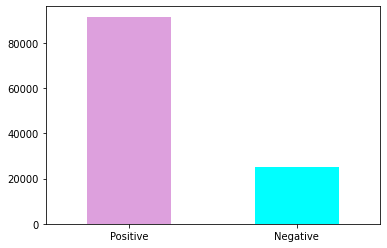

In [33]:
result=df_c['Sentiment'].value_counts()
result.plot(kind='bar', rot=0, color=['plum','cyan']);